In [ ]:
#    Copyright 2020 Arkadip Bhattacharya

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#        http://www.apache.org/licenses/LICENSE-2.0

#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import dataloader
from sklearn.model_selection import train_test_split
from preprocessing import Normalize_df, WindSpeedDataset, ComposeTransform, ToTensor

In [2]:
dataset = Normalize_df(pd.read_csv('./dataset-daily.csv'))
dataset.head()

,time,air_temperature_mean,pressure,wind_direction,wind_speed
0,0.000000,0.370203,0.103164,0.732591,0.625000
1,0.000011,0.322799,0.268912,0.838440,0.354167
2,0.000022,0.302483,0.709078,0.988858,0.260417
3,0.000033,0.246050,0.850758,0.239554,0.093750
4,0.000044,0.194131,0.827372,0.345404,0.291667


In [3]:
trainset, testset = train_test_split(dataset, test_size = 0.1)
trainset, valset = train_test_split(trainset, test_size = 0.1)

In [4]:
trainset.iloc[0]

time                    0.119730
air_temperature_mean    0.562077
pressure                0.550206
wind_direction          0.462396
wind_speed              0.166667
Name: 650, dtype: float64

In [5]:
train_dataset = WindSpeedDataset(trainset,transform=ComposeTransform([ToTensor()]))
test_dataset = WindSpeedDataset(testset, transform=ComposeTransform([ToTensor()]))
val_dataset = WindSpeedDataset(valset, transform=ComposeTransform([ToTensor()]))

In [6]:
train_dataset[0]

(tensor([0.5621, 0.5502, 0.4624], dtype=torch.float64),
 tensor([0.1667], dtype=torch.float64))

In [7]:
batch_size = 32

trainloader = dataloader.DataLoader(train_dataset, batch_size, shuffle = True)
valloader = dataloader.DataLoader(val_dataset, batch_size, shuffle = False)
testloader = dataloader.DataLoader(test_dataset, batch_size, shuffle = False)

In [8]:
cuda = torch.cuda.is_available()
device = torch.device('cuda') if cuda else torch.device('cpu')
if cuda:
    print("Device Count:", torch.cuda.device_count())
    print("Device:", torch.cuda.get_device_name())
    print("Device Capability:", torch.cuda.get_device_capability())

Device Count: 1
Device: GeForce 940MX
Device Capability: (5, 0)


In [9]:
from torch import nn

In [10]:
conv1 = nn.Conv1d(1, 10, 3)

In [11]:
f, l = next(iter(trainloader))

In [13]:
f.shape

torch.Size([32, 3])

In [14]:
conv1(f)

RuntimeError: Expected 3-dimensional input for 3-dimensional weight 10 1 3, but got 2-dimensional input of size [32, 3] instead

In [9]:
from model import Model
model = Model(3, 100, 1, cuda=cuda)
model.to(device)
print(model)

C:\Users\in2ar\.conda\envs\cv\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Model(
  (lstm1): LSTM(3, 100, batch_first=True, dropout=0.2)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [10]:
from torch.optim import Adam
from torch.nn import SmoothL1Loss

trainlosses, testlosses = model.fit(trainloader = trainloader,
                                    validationloader = valloader,
                                    loss = SmoothL1Loss,
                                    optim = Adam,
                                    lr=0.001,
                                    epochs = 20,
                                    val_per_batch = 20)

Epoch: 1 Batch: 0 out of 93 Training Loss: 0.0005129686686941372 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 1 out of 93 Training Loss: 0.0304908919278332 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 2 out of 93 Training Loss: 0.09470503210460626 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 3 out of 93 Training Loss: 0.14049793958103143 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 4 out of 93 Training Loss: 0.19984701826607668 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 5 out of 93 Training Loss: 0.2295725363436886 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 6 out of 93 Training Loss: 0.27246117770111045 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 7 out of 93 Training Loss: 0.29663638576304396 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 8 out of 93 Training Loss: 0.3289236481431671 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 9 out of 93 Training Loss: 0.3524751941803642 Test Loss: 0.06099853833967989
Epoch: 1 Batch: 10 out of 93 Training Loss: 0.3798984344247528

Epoch: 1 Batch: 92 out of 93 Training Loss: 0.14750332919932477 Test Loss: 0.011963869953020052
Epoch: 2 Batch: 0 out of 93 Training Loss: 0.00012529593321584885 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 1 out of 93 Training Loss: 0.010771549757449858 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 2 out of 93 Training Loss: 0.024484823908536665 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 3 out of 93 Training Loss: 0.04220760193082594 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 4 out of 93 Training Loss: 0.057126326005785696 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 5 out of 93 Training Loss: 0.06466167558345103 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 6 out of 93 Training Loss: 0.08193839665862822 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 7 out of 93 Training Loss: 0.0931827309391191 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 8 out of 93 Training Loss: 0.1030607218703916 Test Loss: 0.012146893931044773
Epoch: 2 Batch: 9 out of 93 Training Loss: 0.

Epoch: 3 Batch: 0 out of 93 Training Loss: 0.00014478305695197916 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 1 out of 93 Training Loss: 0.006845092981733302 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 2 out of 93 Training Loss: 0.02221768686888359 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 3 out of 93 Training Loss: 0.03692612855104349 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 4 out of 93 Training Loss: 0.047229262649692516 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 5 out of 93 Training Loss: 0.06522575637666128 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 6 out of 93 Training Loss: 0.08367399556902788 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 7 out of 93 Training Loss: 0.09479539154437921 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 8 out of 93 Training Loss: 0.10267327783969782 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 9 out of 93 Training Loss: 0.11651619674978397 Test Loss: 0.011317790274254301
Epoch: 3 Batch: 10 out of 93 Training Loss: 0

Epoch: 4 Batch: 0 out of 93 Training Loss: 0.00013487099079034662 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 1 out of 93 Training Loss: 0.010211097657360056 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 2 out of 93 Training Loss: 0.020479130208171825 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 3 out of 93 Training Loss: 0.02956600265917919 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 4 out of 93 Training Loss: 0.038286655790783386 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 5 out of 93 Training Loss: 0.05027411004868887 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 6 out of 93 Training Loss: 0.060639970585383396 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 7 out of 93 Training Loss: 0.07007073669103525 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 8 out of 93 Training Loss: 0.08261234557596586 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 9 out of 93 Training Loss: 0.09185838198629759 Test Loss: 0.010103396775031631
Epoch: 4 Batch: 10 out of 93 Training Loss:

Epoch: 5 Batch: 0 out of 93 Training Loss: 0.0001209990111409977 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 1 out of 93 Training Loss: 0.015346496085566218 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 2 out of 93 Training Loss: 0.027852493989211257 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 3 out of 93 Training Loss: 0.03802545899425143 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 4 out of 93 Training Loss: 0.05249562831495398 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 5 out of 93 Training Loss: 0.06196494558725947 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 6 out of 93 Training Loss: 0.07176244603369826 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 7 out of 93 Training Loss: 0.08467850619826907 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 8 out of 93 Training Loss: 0.09844007128749484 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 9 out of 93 Training Loss: 0.1098069461983859 Test Loss: 0.010637175376442346
Epoch: 5 Batch: 10 out of 93 Training Loss: 0.1

Epoch: 6 Batch: 0 out of 93 Training Loss: 8.464424360182977e-05 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 1 out of 93 Training Loss: 0.007499558445546896 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 2 out of 93 Training Loss: 0.014980163950953753 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 3 out of 93 Training Loss: 0.027424149740968018 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 4 out of 93 Training Loss: 0.0394631331456044 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 5 out of 93 Training Loss: 0.05390895024362591 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 6 out of 93 Training Loss: 0.06326440122399118 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 7 out of 93 Training Loss: 0.07521712739441183 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 8 out of 93 Training Loss: 0.08297567308369663 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 9 out of 93 Training Loss: 0.09086994134310272 Test Loss: 0.010027389211410826
Epoch: 6 Batch: 10 out of 93 Training Loss: 0.

Epoch: 6 Batch: 90 out of 93 Training Loss: 0.08466296742594813 Test Loss: 0.010466778989542614
Epoch: 6 Batch: 91 out of 93 Training Loss: 0.09134764789528226 Test Loss: 0.010466778989542614
Epoch: 6 Batch: 92 out of 93 Training Loss: 0.09333653265534912 Test Loss: 0.010466778989542614
Epoch: 7 Batch: 0 out of 93 Training Loss: 9.126947211321964e-05 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 1 out of 93 Training Loss: 0.006226927833130924 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 2 out of 93 Training Loss: 0.017138804168871015 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 3 out of 93 Training Loss: 0.023661421471706003 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 4 out of 93 Training Loss: 0.036796087258926004 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 5 out of 93 Training Loss: 0.0419996095350593 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 6 out of 93 Training Loss: 0.04912484656037983 Test Loss: 0.009912701619958336
Epoch: 7 Batch: 7 out of 93 Training Loss:

Epoch: 7 Batch: 84 out of 93 Training Loss: 0.05074143887198028 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 85 out of 93 Training Loss: 0.059832270375252336 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 86 out of 93 Training Loss: 0.07010327198243198 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 87 out of 93 Training Loss: 0.08147009380793628 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 88 out of 93 Training Loss: 0.08997769851869401 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 89 out of 93 Training Loss: 0.09811943594998178 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 90 out of 93 Training Loss: 0.1070464943785077 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 91 out of 93 Training Loss: 0.11713384289926347 Test Loss: 0.009569583376022902
Epoch: 7 Batch: 92 out of 93 Training Loss: 0.12592993502205668 Test Loss: 0.009569583376022902
Epoch: 8 Batch: 0 out of 93 Training Loss: 0.00011518179008396722 Test Loss: 0.00984381287443367
Epoch: 8 Batch: 1 out of 93 Training Lo

Epoch: 8 Batch: 83 out of 93 Training Loss: 0.034010068859677986 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 84 out of 93 Training Loss: 0.04005789279169984 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 85 out of 93 Training Loss: 0.051920528404187635 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 86 out of 93 Training Loss: 0.06982879421837278 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 87 out of 93 Training Loss: 0.07937869045115657 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 88 out of 93 Training Loss: 0.08758305001236148 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 89 out of 93 Training Loss: 0.09689445222891517 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 90 out of 93 Training Loss: 0.10359158587805577 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 91 out of 93 Training Loss: 0.11224123870186158 Test Loss: 0.009577234317971901
Epoch: 8 Batch: 92 out of 93 Training Loss: 0.12247463257215567 Test Loss: 0.009577234317971901
Epoch: 9 Batch: 0 out of 93 Training L

Epoch: 9 Batch: 81 out of 93 Training Loss: 0.014950975400643723 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 82 out of 93 Training Loss: 0.028618760031896014 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 83 out of 93 Training Loss: 0.03414855254559435 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 84 out of 93 Training Loss: 0.043164507576512474 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 85 out of 93 Training Loss: 0.05412605320780196 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 86 out of 93 Training Loss: 0.0667425748866669 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 87 out of 93 Training Loss: 0.07709072166799225 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 88 out of 93 Training Loss: 0.09079120969145216 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 89 out of 93 Training Loss: 0.10172845618544735 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 90 out of 93 Training Loss: 0.11641395939259447 Test Loss: 0.009517410219731655
Epoch: 9 Batch: 91 out of 93 Training 

Epoch: 10 Batch: 77 out of 93 Training Loss: 0.16397632135092577 Test Loss: 0.009556075473400679
Epoch: 10 Batch: 78 out of 93 Training Loss: 0.17378746660440525 Test Loss: 0.009556075473400679
Epoch: 10 Batch: 79 out of 93 Training Loss: 0.17887675052522978 Test Loss: 0.009556075473400679
Epoch: 10 Batch: 80 out of 93 Training Loss: 0.0019896020199518007 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 81 out of 93 Training Loss: 0.01618286865012453 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 82 out of 93 Training Loss: 0.024527384808228473 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 83 out of 93 Training Loss: 0.03466639844881103 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 84 out of 93 Training Loss: 0.044096296561823345 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 85 out of 93 Training Loss: 0.05494833355949924 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 86 out of 93 Training Loss: 0.061371630897686935 Test Loss: 0.009507972408424725
Epoch: 10 Batch: 87 out o

Epoch: 11 Batch: 77 out of 93 Training Loss: 0.18571970117827719 Test Loss: 0.009557563218880783
Epoch: 11 Batch: 78 out of 93 Training Loss: 0.198653760082925 Test Loss: 0.009557563218880783
Epoch: 11 Batch: 79 out of 93 Training Loss: 0.21027045668652122 Test Loss: 0.009557563218880783
Epoch: 11 Batch: 80 out of 93 Training Loss: 0.0023411762800097536 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 81 out of 93 Training Loss: 0.019294551470506197 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 82 out of 93 Training Loss: 0.02310203121900857 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 83 out of 93 Training Loss: 0.03156356433332265 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 84 out of 93 Training Loss: 0.03960581602454484 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 85 out of 93 Training Loss: 0.046886948998275405 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 86 out of 93 Training Loss: 0.059958089272680884 Test Loss: 0.009465552781793203
Epoch: 11 Batch: 87 out of 

Epoch: 12 Batch: 77 out of 93 Training Loss: 0.15682794028674643 Test Loss: 0.010011413473297249
Epoch: 12 Batch: 78 out of 93 Training Loss: 0.1656318592444567 Test Loss: 0.010011413473297249
Epoch: 12 Batch: 79 out of 93 Training Loss: 0.1767552445248274 Test Loss: 0.010011413473297249
Epoch: 12 Batch: 80 out of 93 Training Loss: 0.001987276695525035 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 81 out of 93 Training Loss: 0.009420867174720153 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 82 out of 93 Training Loss: 0.022099613308762894 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 83 out of 93 Training Loss: 0.030722160920357094 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 84 out of 93 Training Loss: 0.036605402923976765 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 85 out of 93 Training Loss: 0.044588911443805085 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 86 out of 93 Training Loss: 0.053263216376160966 Test Loss: 0.009548681407150898
Epoch: 12 Batch: 87 out o

Epoch: 13 Batch: 78 out of 93 Training Loss: 0.17371902421596408 Test Loss: 0.009628118989481167
Epoch: 13 Batch: 79 out of 93 Training Loss: 0.18504906811299682 Test Loss: 0.009628118989481167
Epoch: 13 Batch: 80 out of 93 Training Loss: 0.002130423361306844 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 81 out of 93 Training Loss: 0.011804028102999388 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 82 out of 93 Training Loss: 0.019932121658569037 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 83 out of 93 Training Loss: 0.02906839611554688 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 84 out of 93 Training Loss: 0.033834169307594954 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 85 out of 93 Training Loss: 0.04602638321543282 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 86 out of 93 Training Loss: 0.05638135938519782 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 87 out of 93 Training Loss: 0.06766289813989942 Test Loss: 0.009517677255313505
Epoch: 13 Batch: 88 out of

Epoch: 14 Batch: 78 out of 93 Training Loss: 0.186286026242653 Test Loss: 0.009486186191100966
Epoch: 14 Batch: 79 out of 93 Training Loss: 0.19940198362199413 Test Loss: 0.009486186191100966
Epoch: 14 Batch: 80 out of 93 Training Loss: 0.0023610227331068295 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 81 out of 93 Training Loss: 0.0075971538722064275 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 82 out of 93 Training Loss: 0.01646368937189839 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 83 out of 93 Training Loss: 0.02910848321016095 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 84 out of 93 Training Loss: 0.03788116281475089 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 85 out of 93 Training Loss: 0.04806193602825663 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 86 out of 93 Training Loss: 0.054472757834896066 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 87 out of 93 Training Loss: 0.06736755776773355 Test Loss: 0.009522587653588165
Epoch: 14 Batch: 88 out of 

Epoch: 15 Batch: 80 out of 93 Training Loss: 0.002039498013391141 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 81 out of 93 Training Loss: 0.010682829950883035 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 82 out of 93 Training Loss: 0.018809682984783298 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 83 out of 93 Training Loss: 0.03135222878022397 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 84 out of 93 Training Loss: 0.04091075371666158 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 85 out of 93 Training Loss: 0.04872581857903207 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 86 out of 93 Training Loss: 0.05740174028737748 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 87 out of 93 Training Loss: 0.07164137560589517 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 88 out of 93 Training Loss: 0.08052092540724481 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 89 out of 93 Training Loss: 0.08563932386873568 Test Loss: 0.009534647180275484
Epoch: 15 Batch: 90 out of 

Epoch: 16 Batch: 73 out of 93 Training Loss: 0.12559505206933205 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 74 out of 93 Training Loss: 0.13312441417416518 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 75 out of 93 Training Loss: 0.14127574795326178 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 76 out of 93 Training Loss: 0.15411328458627646 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 77 out of 93 Training Loss: 0.16465297834416812 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 78 out of 93 Training Loss: 0.17761728288074916 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 79 out of 93 Training Loss: 0.18756184288701003 Test Loss: 0.009498044213449413
Epoch: 16 Batch: 80 out of 93 Training Loss: 0.002120994745386179 Test Loss: 0.009492371104318987
Epoch: 16 Batch: 81 out of 93 Training Loss: 0.011700719377589758 Test Loss: 0.009492371104318987
Epoch: 16 Batch: 82 out of 93 Training Loss: 0.026871738738012844 Test Loss: 0.009492371104318987
Epoch: 16 Batch: 83 out of 

Epoch: 17 Batch: 77 out of 93 Training Loss: 0.16644767770462449 Test Loss: 0.009416729169474407
Epoch: 17 Batch: 78 out of 93 Training Loss: 0.17473141109489615 Test Loss: 0.009416729169474407
Epoch: 17 Batch: 79 out of 93 Training Loss: 0.18457614077173884 Test Loss: 0.009416729169474407
Epoch: 17 Batch: 80 out of 93 Training Loss: 0.0020803980415058836 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 81 out of 93 Training Loss: 0.009775663155813286 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 82 out of 93 Training Loss: 0.014306645735849211 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 83 out of 93 Training Loss: 0.02024974523832328 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 84 out of 93 Training Loss: 0.02865709959318168 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 85 out of 93 Training Loss: 0.03806519544472224 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 86 out of 93 Training Loss: 0.04613459891428477 Test Loss: 0.00954313792118972
Epoch: 17 Batch: 87 out of 93 Tra

Epoch: 18 Batch: 80 out of 93 Training Loss: 0.0020387643232488107 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 81 out of 93 Training Loss: 0.007569221335604138 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 82 out of 93 Training Loss: 0.015291417504801699 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 83 out of 93 Training Loss: 0.024471307660593935 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 84 out of 93 Training Loss: 0.031079118627264448 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 85 out of 93 Training Loss: 0.040140093791439485 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 86 out of 93 Training Loss: 0.0516754626512074 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 87 out of 93 Training Loss: 0.06166920300866599 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 88 out of 93 Training Loss: 0.07139690827871795 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 89 out of 93 Training Loss: 0.0868765791162395 Test Loss: 0.00940821785479784
Epoch: 18 Batch: 90 out of 93 Train

Epoch: 19 Batch: 76 out of 93 Training Loss: 0.1594127208156952 Test Loss: 0.010159824974834919
Epoch: 19 Batch: 77 out of 93 Training Loss: 0.16670080657810657 Test Loss: 0.010159824974834919
Epoch: 19 Batch: 78 out of 93 Training Loss: 0.17333015205100863 Test Loss: 0.010159824974834919
Epoch: 19 Batch: 79 out of 93 Training Loss: 0.17995023878053515 Test Loss: 0.010159824974834919
Epoch: 19 Batch: 80 out of 93 Training Loss: 0.001965785077296832 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 81 out of 93 Training Loss: 0.011586416190945246 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 82 out of 93 Training Loss: 0.018790746251576285 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 83 out of 93 Training Loss: 0.02672203085803304 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 84 out of 93 Training Loss: 0.03469812511884485 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 85 out of 93 Training Loss: 0.043207952896588186 Test Loss: 0.009476633954115889
Epoch: 19 Batch: 86 out of 

Epoch: 20 Batch: 72 out of 93 Training Loss: 0.11933670455192666 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 73 out of 93 Training Loss: 0.12971064431195597 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 74 out of 93 Training Loss: 0.1436214380112801 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 75 out of 93 Training Loss: 0.1545026281995092 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 76 out of 93 Training Loss: 0.16217510757570605 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 77 out of 93 Training Loss: 0.17382334621225934 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 78 out of 93 Training Loss: 0.1841577895132218 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 79 out of 93 Training Loss: 0.19405715429758172 Test Loss: 0.009282324801791798
Epoch: 20 Batch: 80 out of 93 Training Loss: 0.0022017781113558284 Test Loss: 0.009321686981076544
Epoch: 20 Batch: 81 out of 93 Training Loss: 0.013269426529603529 Test Loss: 0.009321686981076544
Epoch: 20 Batch: 82 out of 93 

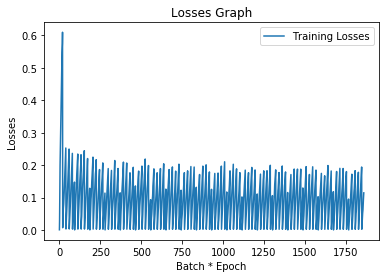

In [12]:
plt.plot(trainlosses, label = 'Training Losses')
#plt.plot(testlosses, label = 'Testing Losses')
plt.ylabel('Losses')
plt.xlabel('Batch * Epoch')
plt.legend()
plt.title('Losses Graph')
plt.show()

In [13]:
result, expected = model.test(testloader)

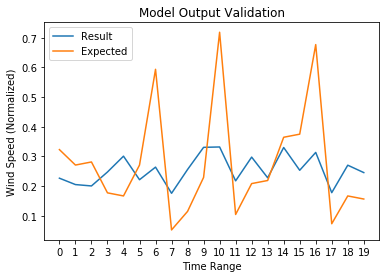

In [15]:
val_from = 0
val_to = 20

plt.plot(result[val_from:val_to], label = 'Result')
plt.plot(expected[val_from:val_to], label = 'Expected')
plt.ylabel('Wind Speed (Normalized)')
plt.xticks(range(val_from, val_to))
plt.xlabel('Time Range')
plt.legend()
plt.title('Model Output Validation')
plt.show()

In [ ]:
model.save('v1', save_optim=True, cuda=cuda)